In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
df1 = pd.read_parquet("../data/original/yellow_tripdata_2009-01.parquet")


In [3]:
df1.columns

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')

In [3]:
df1 = df1.drop(columns=['vendor_name','Rate_Code','store_and_forward',
                  'Payment_Type', 'mta_tax','surcharge', 'Tip_Amt','Tolls_Amt','Trip_Dropoff_DateTime'])

In [77]:
df1.shape

(14092413, 18)

# Análisis Filtros de calidad


## Filtros generales (aplicables a Train, Test y Producción)
- **Haversine distance ≤ 800 km**  
  - Valores mayores a 800 km son físicamente imposibles en un contexto urbano o metropolitano.  
  - Eliminar estos casos evita que rutas extremadamente largas distorsionen los modelos y métricas.

- **Latitudes y longitudes válidas (-90 ≤ Lat ≤ 90, -180 ≤ Lon ≤ 180)**  
  - Coordenadas fuera de rango indican errores de GPS.  
  - Esos errores afectan cualquier cálculo de distancia, velocidad o ruta.

## Filtros específicos de entrenamiento y testeo

- **Tiempo de viaje > 0**  
  - Viajes con tiempo 0 son imposibles; eliminarlos asegura consistencia en features de duración y velocidad.

- **Velocidad real < 300 km/h**  
  - Velocidades mayores son físicamente imposibles en un taxi urbano.  
  - Valores extremos distorsionan la velocidad promedio y cualquier feature derivada.

- **Tiempo de viaje < 32 días**  
  - Evita registros con errores masivos en timestamp o GPS que generan viajes absurdamente largos.

- **Combinación de tiempo, velocidad y distancia:**  
  - `(Tiempo ≥ 30 min) & (Velocidad ≥ 100 km/h) & (Distancia > 56 km)`  
  - Este filtro elimina viajes donde el taxi habría ido demasiado rápido para la distancia indicada, evitando outliers graves.

- **Ratio Haversine / Real distance**  
  - `ratio_haversine_real < 100`  
    - Elimina valores extremadamente inconsistentes que afectan la relación distancia calculada vs. reportada.  
  - Filtros adicionales
  - Garantiza que la distancia reportada nunca sea menor que la distancia mínima geométrica (evita grandes desviaciones)  
  - Evita casos donde el GPS se desvió fuertemente y el cálculo de tarifa podría ser incorrecto.
    - `(ratio > 40) & (Real_distance > 0.8 km)`  
    - `(ratio > 15) & (Real_distance > 5 km)`  
    - `(ratio > 6) & (Real_distance > 0.2 km)`  
    - `(ratio > 4) & (Real_distance > 0.5 km)`  
    - `(ratio > 3) & (Real_distance > 1 km)`  
  - Estos eliminan outliers que representan errores de GPS graves o medición de distancia imposible.  

## Nota general
- Todos estos filtros están diseñados para **eliminar únicamente outliers extremos** que afectarían el cálculo de tarifas, velocidades o distancias.  
- Los valores normales, aunque tengan cierta variabilidad, se mantienen para preservar información útil para los modelos.


In [78]:
# Convertir a datetime
df1['Trip_Pickup_DateTime'] = pd.to_datetime(df1['Trip_Pickup_DateTime'])
df1['Trip_Dropoff_DateTime'] = pd.to_datetime(df1['Trip_Dropoff_DateTime'])

# Calcular duración en segundos
df1['Real_time'] = (df1['Trip_Dropoff_DateTime'] - df1['Trip_Pickup_DateTime']).dt.total_seconds()
df1['Real_distance'] = df1['Trip_Distance'] * 1609.34
df1['Real_velocity'] = df1['Real_distance']/ df1['Real_time'] 

In [79]:

df1 =df1[['Start_Lon','Start_Lat','End_Lon','End_Lat','Real_time','Real_velocity','Real_distance','Fare_Amt','Total_Amt']]

In [80]:
def km_m(kmh):
    return kmh*1000
def kmh_to_ms(kmh):
    return kmh * 1000 / 3600
def days_to_s(days):
    return days * 24 * 60 * 60
def min_to_s(mins):
    return mins*60
def haversine_distance(df):
    # Radio de la Tierra en km
    R = 6371.0
    # Convertir a radianes
    lon1 = np.radians(df['Start_Lon'])
    lat1 = np.radians(df['Start_Lat'])
    lon2 = np.radians(df['End_Lon'])
    lat2 = np.radians(df['End_Lat'])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    df['haversine_distance_m'] = R * c * 1000
    return df
    


In [ ]:
print(df1.shape)
# Quitar valores fuera de rango válido
df1 = df1[
    (df1['Start_Lat'].between(-90, 90)) &
    (df1['End_Lat'].between(-90, 90)) &
    (df1['Start_Lon'].between(-180, 180)) &
    (df1['End_Lon'].between(-180, 180))
].copy()
print(df1.shape)

(14092413, 9)
(14092401, 9)


In [82]:
df1 = df1[df1['Real_time']>0.0]
df1 = df1[df1['Real_distance']>0.0]
df1 = df1[df1['Real_velocity'] < kmh_to_ms(300)]
df1 = df1[df1['Real_time'] < days_to_s(32)]
df1 = df1[(df1['Real_time'] < min_to_s(30)) & (df1['Real_velocity'] <= kmh_to_ms(100)) & (df1['Real_distance'] <= 56000)] #Podria estar perdiendo dinero la empresa


In [83]:
df1 = haversine_distance(df1)

In [84]:
df1 = df1[df1['haversine_distance_m'] <= km_m(800)]

In [85]:
# 1. Relación Haversine / Real
df1['ratio_haversine_real'] = df1['haversine_distance_m'] / df1['Real_distance']


In [86]:
df1.shape

(13284697, 11)

In [87]:
# Filtrar solo outliers extremos, manteniendo todo lo demás
df1 = df1[df1['ratio_haversine_real'] < 80]
df1 = df1[~((df1['ratio_haversine_real'] > 40) & (df1['Real_distance'] > km_m(0.8)))]
df1 = df1[~((df1['ratio_haversine_real'] > 15) & (df1['Real_distance'] > km_m(5)))]


In [88]:
df1.shape

(13283221, 11)

In [89]:
import matplotlib.pyplot as plt

def plot_boxplot_with_outliers(df, column):
    data = df[column].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Calcular outliers
    outliers = data[(data < lower) | (data > upper)]
    n_outliers = len(outliers)
    
    # Mostrar boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, vert=False, showfliers=True)
    plt.title(f'Boxplot de {column} (Outliers: {n_outliers})', fontsize=14)
    plt.xlabel(column)
    plt.show()
    
    print(f"Valores fuera de los whiskers: {n_outliers}")
    return outliers

# Ejemplo


In [90]:
df1.nlargest(100, columns='ratio_haversine_real')

,Start_Lon,Start_Lat,End_Lon,End_Lat,Real_time,Real_velocity,Real_distance,Fare_Amt,Total_Amt,haversine_distance_m,ratio_haversine_real
976537,-74.010162,40.720443,-74.006703,40.708012,420.0,0.042149,17.70274,5.7,6.2,1412.673384,79.799702
6734607,-73.987234,40.779117,-73.981180,40.779621,218.0,0.029529,6.43736,4.1,4.1,512.819228,79.662972
12329331,-73.772512,40.666897,-73.980545,40.762228,60.0,4.291573,257.49440,2.5,2.5,20488.772682,79.569780
11118408,-73.988103,40.760650,-73.981358,40.770918,480.0,0.033528,16.09340,5.3,5.3,1275.252321,79.240702
9939938,-73.518402,40.759814,-73.972040,40.757715,161.0,2.998770,482.80200,3.3,3.8,38208.910985,79.139919
...,...,...,...,...,...,...,...,...,...,...,...
2206320,-73.978368,40.752365,-73.991157,40.750575,180.0,0.089408,16.09340,4.1,4.1,1095.520918,68.072683
8057505,-73.925832,40.691763,-73.985890,40.763037,480.0,0.288340,138.40324,5.7,6.7,9403.332560,67.941564
11005842,-73.781677,40.644772,-73.971660,40.579972,1440.0,0.179933,259.10374,36.1,36.6,17581.107499,67.853546
9382997,-74.015052,40.711227,-73.997118,40.723917,600.0,0.050962,30.57746,8.1,9.1,2067.747750,67.623267


In [91]:
# Crear una máscara para identificar viajes donde Real_distance < haversine_distance_m
mask_real_menor_haversine = df1['Real_distance'] < df1['haversine_distance_m']

# Filtrar esos registros
outliers_real_menor_haversine = df1[mask_real_menor_haversine]

# Revisar cuántos hay
print("Número de viajes donde Real < Haversine:", len(outliers_real_menor_haversine))

Número de viajes donde Real < Haversine: 790514


In [92]:
df1.shape

(13283221, 11)

In [93]:
df1 = df1[~(
    ((df1['ratio_haversine_real'] > 3) & (df1['Real_distance'] > km_m(1))) |
    ((df1['ratio_haversine_real'] > 4) & (df1['Real_distance'] > km_m(0.5))) |
    ((df1['ratio_haversine_real'] > 6) & (df1['Real_distance'] > km_m(0.2)))
)]

In [94]:
df1.shape

(13203220, 11)

In [95]:
df1.describe()

,Start_Lon,Start_Lat,End_Lon,End_Lat,Real_time,Real_velocity,Real_distance,Fare_Amt,Total_Amt,haversine_distance_m,ratio_haversine_real
count,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07,1.320322e+07
mean,-7.293087e+01,4.017775e+01,-7.292924e+01,4.017812e+01,6.049198e+02,6.050151e+00,3.762609e+03,8.829683e+00,9.482978e+00,2.742569e+03,7.806193e-01
std,8.733345e+00,4.811467e+00,8.733153e+00,4.811531e+00,3.592555e+02,3.173872e+00,3.700784e+03,5.346285e+00,6.099424e+00,2.605101e+03,5.325281e-01
min,-9.367824e+01,-6.936300e-02,-9.367824e+01,-7.669300e-02,6.000000e+00,1.277254e-03,1.609340e+00,2.500000e+00,2.500000e+00,0.000000e+00,0.000000e+00
25%,-7.399153e+01,4.073684e+01,-7.399104e+01,4.073637e+01,3.300000e+02,4.023350e+00,1.609340e+03,5.400000e+00,5.800000e+00,1.147119e+03,6.885568e-01
50%,-7.398159e+01,4.075409e+01,-7.398003e+01,4.075452e+01,5.400000e+02,5.340730e+00,2.574944e+03,7.300000e+00,7.800000e+00,1.948257e+03,7.688494e-01
75%,-7.396814e+01,4.076803e+01,-7.396506e+01,4.076923e+01,8.020000e+02,7.167101e+00,4.506152e+03,1.050000e+01,1.100000e+01,3.412105e+03,8.696771e-01
max,9.812700e-02,8.153500e+01,1.014050e-01,8.153500e+01,1.799000e+03,2.777602e+01,4.625243e+04,2.000000e+02,2.340000e+02,9.990256e+04,7.979970e+01


array([[<Axes: title={'center': 'Real_time'}>,
        <Axes: title={'center': 'Real_velocity'}>,
        <Axes: title={'center': 'Real_distance'}>],
       [<Axes: title={'center': 'Fare_Amt'}>,
        <Axes: title={'center': 'Total_Amt'}>,
        <Axes: title={'center': 'haversine_distance_m'}>],
       [<Axes: title={'center': 'ratio_haversine_real'}>, <Axes: >,
        <Axes: >]], dtype=object)

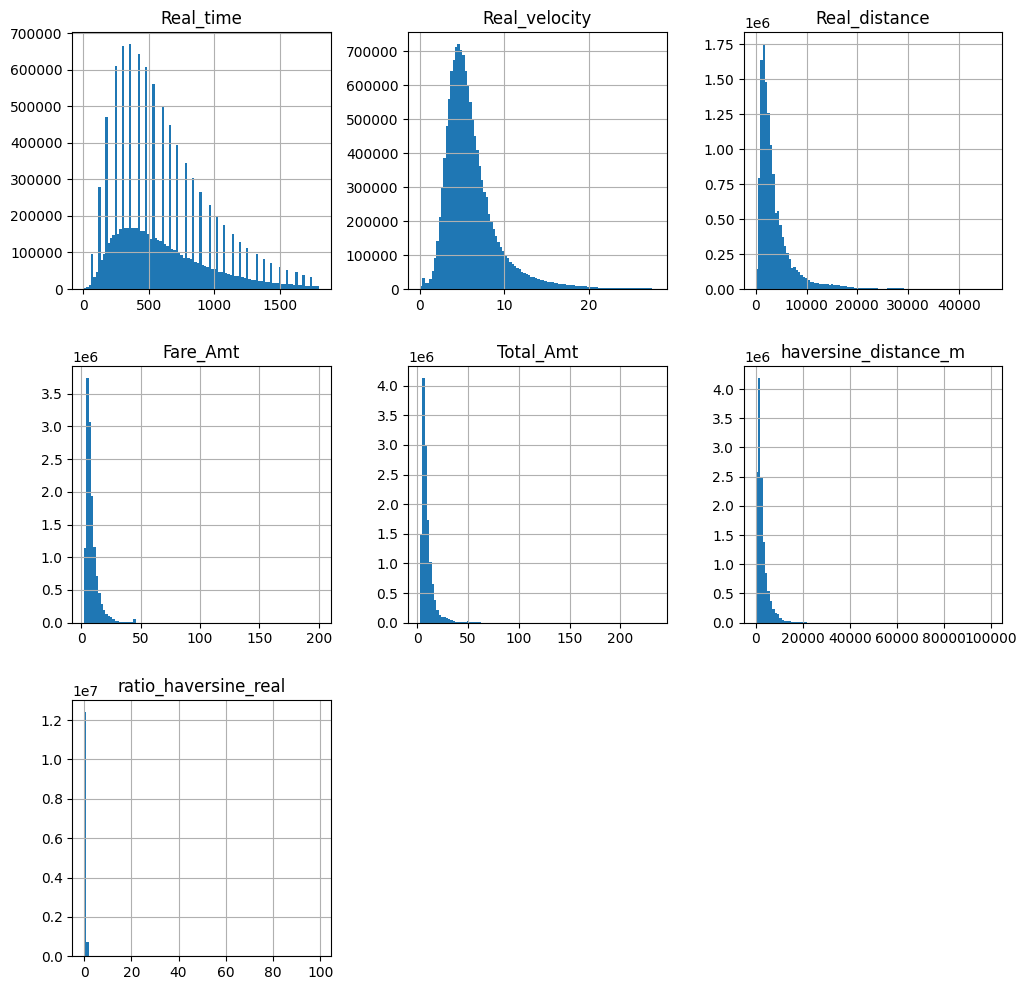

In [73]:
df1[['Real_time',
       'Real_velocity', 'Real_distance', 'Fare_Amt', 'Total_Amt',
       'haversine_distance_m', 'ratio_haversine_real']].hist(bins=100, figsize=(12,12))


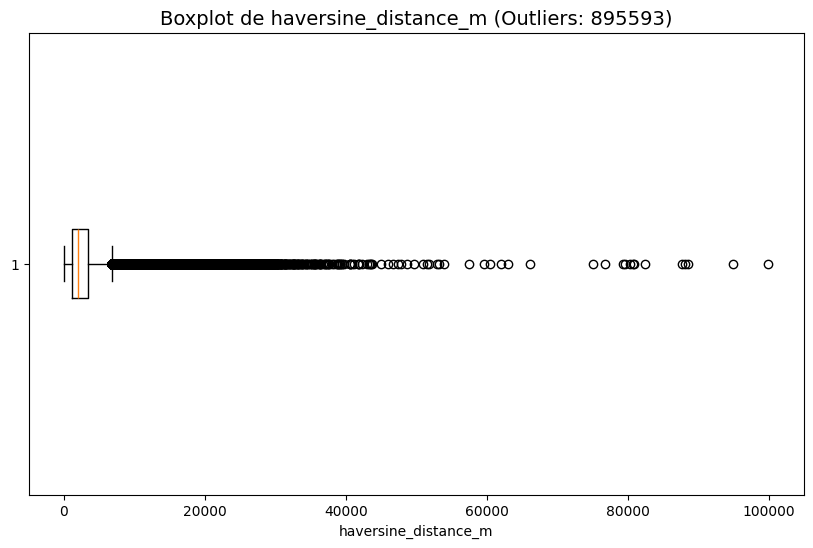

Valores fuera de los whiskers: 895593


2           11672.167416
3            6835.176748
34           8448.624174
37           6866.817914
45          13970.106053
                ...     
14092298    14550.047143
14092343    12494.452113
14092345     9272.743676
14092367     9565.177386
14092380     7012.628578
Name: haversine_distance_m, Length: 895593, dtype: float64

In [97]:
plot_boxplot_with_outliers(df1, 'haversine_distance_m')

In [4]:
import pandas as pd
df_passenger = pd.read_parquet("../data/raw/train.parquet")

In [5]:
df_passenger[df_passenger['Passenger_Count'] >= 10]

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Total_Amt
19689778,2009-02-13 08:43:00,2009-02-13 08:44:00,208,0.00,-73.937905,40.758222,-73.937908,40.758215,2.90,2.90
19698415,2009-02-13 09:01:00,2009-02-13 09:02:00,208,0.00,-73.937788,40.758235,-73.937710,40.758218,3.10,3.10
19709963,2009-02-13 09:26:00,2009-02-13 09:26:00,208,0.00,-73.937823,40.758207,-73.937825,40.758225,2.70,2.70
19715879,2009-02-13 09:40:00,2009-02-13 09:40:00,208,0.00,-73.937755,40.758307,-73.937818,40.758257,2.70,2.70
19716656,2009-02-13 09:42:00,2009-02-13 09:49:00,208,0.00,-73.937895,40.758208,-73.937980,40.758073,5.50,5.50
19727797,2009-02-13 10:09:00,2009-02-13 10:13:00,208,0.00,-73.937867,40.758250,-73.937848,40.758190,4.09,4.09
19730683,2009-02-13 10:17:00,2009-02-13 10:17:00,208,0.00,-73.937867,40.758250,-73.937872,40.758280,2.70,5.70
19732499,2009-02-13 10:22:00,2009-02-13 10:22:00,208,0.00,0.000000,0.000000,0.000000,0.000000,2.70,2.70
19732838,2009-02-13 10:23:00,2009-02-13 10:23:00,208,0.00,-73.937783,40.758183,-73.937803,40.758187,2.70,5.70
19733410,2009-02-13 10:25:00,2009-02-13 10:25:00,208,0.00,-73.937862,40.758183,-73.937803,40.758187,2.70,2.70
